In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive 

In [ ]:
import os
os.chdir("drive/Colab Notebooks") 

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])


import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:


sales_train_validation = pd.read_csv('/content/drive/Colab Notebooks/CNN_Codes/data-sets/sales_train_validation.csv')
calendar = pd.read_csv('/content/drive/Colab Notebooks/CNN_Codes/data-sets/calendar.csv')
sales_prices = pd.read_csv('/content/drive/Colab Notebooks/CNN_Codes/data-sets/sell_prices.csv')

In [ ]:
def reduce_mem_usage(df, verbose=True):

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    # Calculate the currently occupied memory 
    start_mem = df.memory_usage(deep=True).sum() / 1024**2

    # loop through each column
    for col in df.columns:

        # Get the data type of each column
        col_type = df[col].dtypes

        # If the data type is one of the types defined above
        if col_type in numerics:

            # Calculate the minimum and maximum values of the column data for us to specify the corresponding data type
            c_min = df[col].min()
            c_max = df[col].max()

            # If the data type of the column is of type int, then judge
            if str(col_type)[:3] == 'int':
                # If the minimum value of the column is greater than the minimum value of the int8 type, and the maximum value is less than the maximum value of the int8 type, the int8 type is used 
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)

                
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)

                
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)

       
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)

            # Otherwise, use float processing method       
            else:

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)

                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage(deep=True).sum() / 1024**2

    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
sales_bd = np.round(sales_train_validation.memory_usage().sum()/(1024*1024),1)
calendar_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(sales_prices.memory_usage().sum()/(1024*1024),1)

In [ ]:
sales_train_validation = reduce_mem_usage(sales_train_validation)
sales_prices = reduce_mem_usage(sales_prices)
calendar = reduce_mem_usage(calendar)

Mem. usage decreased to 105.38 Mb (76.9% reduction)
Mem. usage decreased to 892.28 Mb (6.8% reduction)
Mem. usage decreased to  0.63 Mb (12.3% reduction)


In [ ]:
sales_ad = np.round(sales_train_validation.memory_usage().sum()/(1024*1024),1)
calendar_ad = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(sales_prices.memory_usage().sum()/(1024*1024),1)

In [ ]:
memory = pd.DataFrame({
    'DataFrame':['sale_train_val','sale_prices','calendar'],
    'Before memory reducing':[sales_bd,prices_bd,calendar_bd],
    'After memory reducing':[sales_ad,prices_ad,calendar_ad],

})

memory = pd.melt(memory,id_vars='DataFrame',var_name='Status',value_name='Memory(MB)')
memory.sort_values('Memory(MB)',inplace=True)
fig = px.bar(memory,x='DataFrame',y='Memory(MB)',color='Status',barmode='group',text='Memory(MB)')
fig.update_traces(textposition='outside')
fig.update_layout(template='seaborn',title='Effect of Downcasting')
fig.show()

In [ ]:
#Sample sales data
ids = sorted(list(sales_train_validation['id']))

d_cols = [c for c in sales_train_validation.columns if 'd_' in c ]

In [ ]:
x_1 = sales_train_validation.loc[sales_train_validation['id'] == ids[2]].set_index('id')[d_cols].values[0] 
x_2 = sales_train_validation.loc[sales_train_validation['id'] == ids[6]].set_index('id')[d_cols].values[0]
x_3 = sales_train_validation.loc[sales_train_validation['id'] == ids[7]].set_index('id')[d_cols].values[0]

fig = make_subplots(rows=3,cols=1)

fig.add_traces(go.Scatter(x=np.arange(len(x_1)),y=x_1,showlegend=False,mode='lines',name='First sample',marker=dict(color=next(color_cycle)))
               ,rows=1,cols=1)

fig.add_traces(go.Scatter(x=np.arange(len(x_2)),y=x_2,showlegend=False,mode='lines',name='Second sample',marker=dict(color=next(color_cycle)))
                ,rows=2,cols=1)

fig.add_traces(go.Scatter(x=np.arange(len(x_3)),y=x_3,showlegend=False,mode='lines',name='Third sample',marker=dict(color=next(color_cycle)))
                ,rows=3,cols=1)

fig.update_layout(height =1200,width=800,title_text='Sample sales')
fig.show()

In [ ]:
x_1 = sales_train_validation.loc[sales_train_validation['id'] == ids[2]].set_index('id')[d_cols].values[0][0:90] 
x_2 = sales_train_validation.loc[sales_train_validation['id'] == ids[6]].set_index('id')[d_cols].values[0][90:180] 
x_3 = sales_train_validation.loc[sales_train_validation['id'] == ids[7]].set_index('id')[d_cols].values[0][1800:] 

fig = make_subplots(rows=3,cols=1)

fig.add_traces(go.Scatter(x=np.arange(len(x_1)),y=x_1,showlegend=False,mode='lines',name='First sample',marker=dict(color=next(color_cycle)))
               ,rows=1,cols=1) # Specifies the subplot to draw

fig.add_traces(go.Scatter(x=np.arange(len(x_2)),y=x_2,showlegend=False,mode='lines',name='Second sample',marker=dict(color=next(color_cycle)))
                ,rows=2,cols=1)

fig.add_traces(go.Scatter(x=np.arange(len(x_3)),y=x_3,showlegend=False,mode='lines',name='Third sample',marker=dict(color=next(color_cycle)))
                ,rows=3,cols=1)

fig.update_layout(height =1200,width=800,title_text='Sample sales')
fig.show()

In [ ]:
ids = sorted(list(sales_train_validation['id']))

d_cols = [c for c in sales_train_validation.columns if 'd_' in c ]

In [ ]:
x_1 = sales_train_validation.loc[sales_train_validation['id'] == ids[2]].set_index('id')[d_cols].values[0] 
x_2 = sales_train_validation.loc[sales_train_validation['id'] == ids[6]].set_index('id')[d_cols].values[0]
x_3 = sales_train_validation.loc[sales_train_validation['id'] == ids[7]].set_index('id')[d_cols].values[0]

fig = make_subplots(rows=3,cols=1)

fig.add_traces(go.Scatter(x=np.arange(len(x_1)),y=x_1,showlegend=False,mode='lines',name='First sample',marker=dict(color=next(color_cycle)))
               ,rows=1,cols=1)

fig.add_traces(go.Scatter(x=np.arange(len(x_2)),y=x_2,showlegend=False,mode='lines',name='Second sample',marker=dict(color=next(color_cycle)))
                ,rows=2,cols=1)

fig.add_traces(go.Scatter(x=np.arange(len(x_3)),y=x_3,showlegend=False,mode='lines',name='Third sample',marker=dict(color=next(color_cycle)))
                ,rows=3,cols=1)

fig.update_layout(height =1200,width=800,title_text='Sample sales')
fig.show()

In [ ]:
x_1 = sales_train_validation.loc[sales_train_validation['id'] == ids[2]].set_index('id')[d_cols].values[0][0:90] 
x_2 = sales_train_validation.loc[sales_train_validation['id'] == ids[6]].set_index('id')[d_cols].values[0][90:180] 
x_3 = sales_train_validation.loc[sales_train_validation['id'] == ids[7]].set_index('id')[d_cols].values[0][1800:] 

fig = make_subplots(rows=3,cols=1)

fig.add_traces(go.Scatter(x=np.arange(len(x_1)),y=x_1,showlegend=False,mode='lines',name='First sample',marker=dict(color=next(color_cycle)))
               ,rows=1,cols=1) # 指定绘制的子图

fig.add_traces(go.Scatter(x=np.arange(len(x_2)),y=x_2,showlegend=False,mode='lines',name='Second sample',marker=dict(color=next(color_cycle)))
                ,rows=2,cols=1)

fig.add_traces(go.Scatter(x=np.arange(len(x_3)),y=x_3,showlegend=False,mode='lines',name='Third sample',marker=dict(color=next(color_cycle)))
                ,rows=3,cols=1)

fig.update_layout(height =1200,width=800,title_text='Sample sales')
fig.show()

In [ ]:
#wavelet denoising
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')

In [ ]:
#denoising
y_w1 = denoise_signal(x_1)
y_w2 = denoise_signal(x_2)
y_w3 = denoise_signal(x_3)

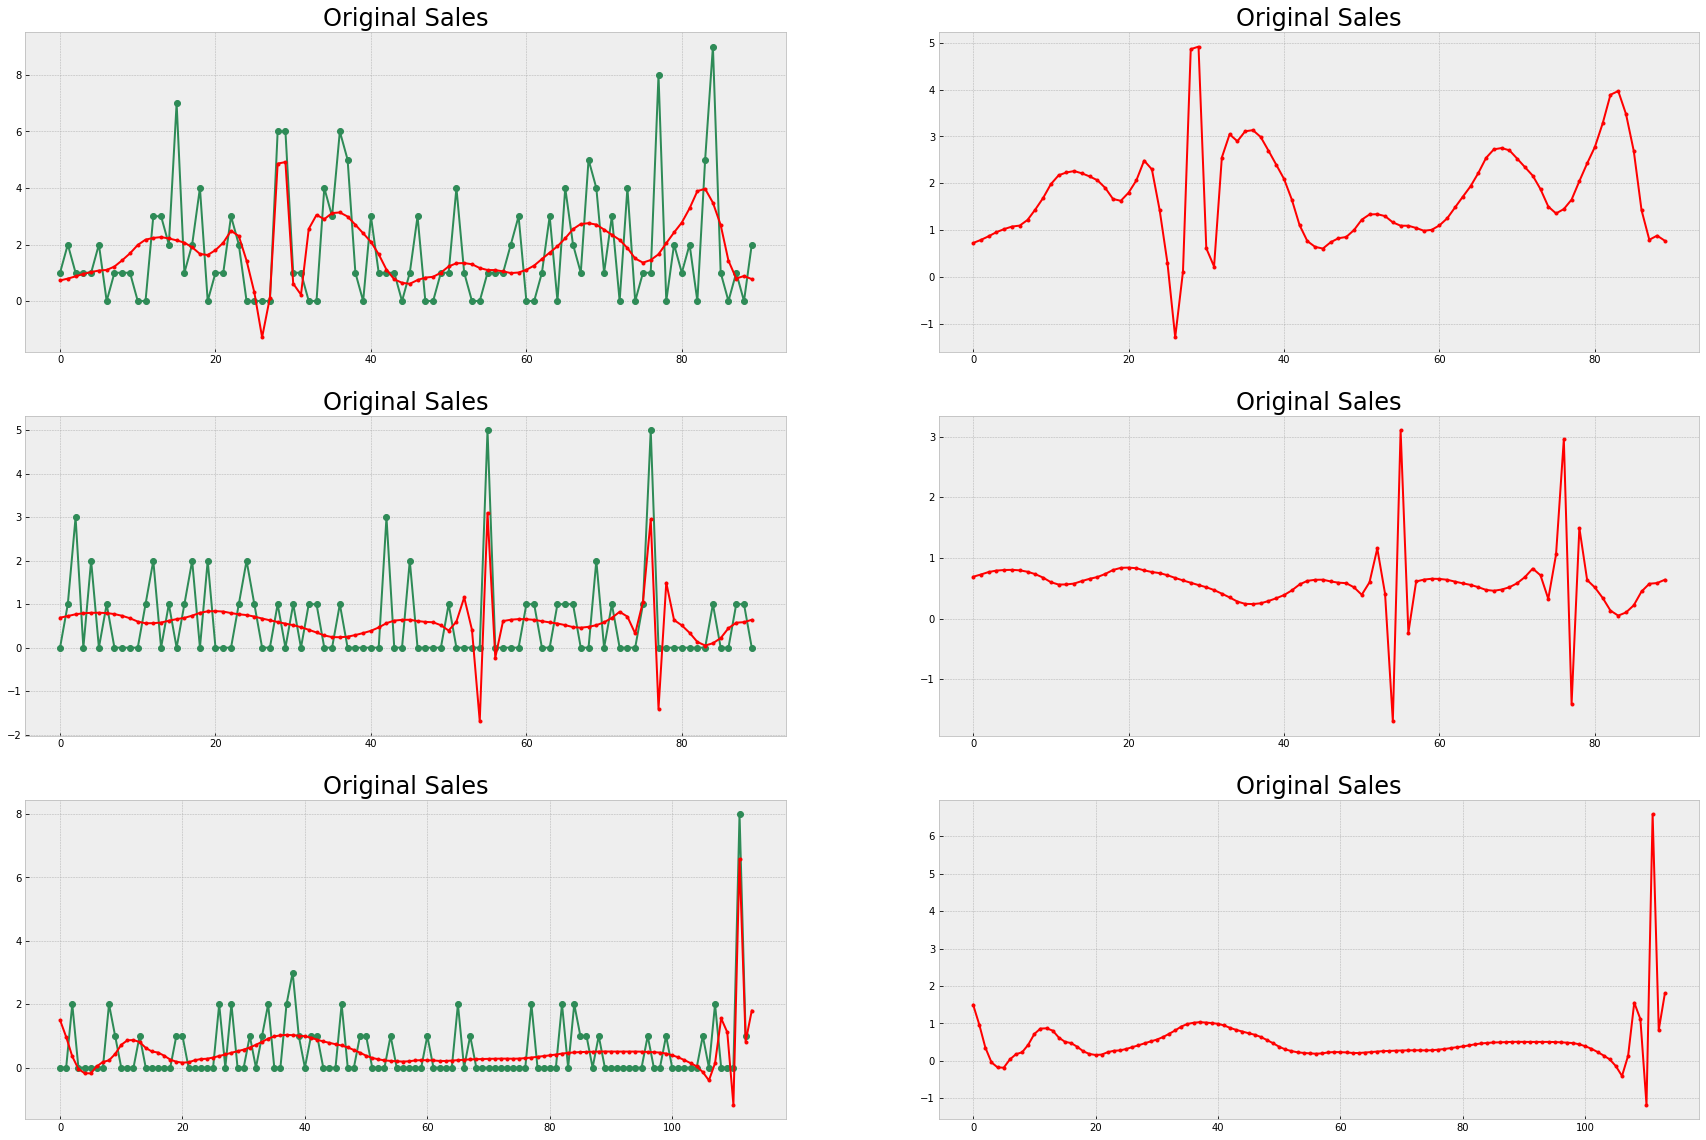

In [ ]:
#The red graph represents the original sales and the green graph represents the denoised sales
fig,ax=plt.subplots(nrows=3,ncols=2,figsize=(30,20))

ax[0,0].plot(x_1,color='seagreen',marker='o')
ax[0,0].set_title('Original Sales',fontsize=24)
ax[0,0].plot(y_w1,color='red',marker='.')
ax[0,0].set_title('Original Sales',fontsize=24)
ax[0,1].plot(y_w1,color='red',marker='.')
ax[0,1].set_title('Original Sales',fontsize=24)

ax[1,0].plot(x_2,color='seagreen',marker='o')
ax[1,0].set_title('Original Sales',fontsize=24)
ax[1,0].plot(y_w2,color='red',marker='.')
ax[1,0].set_title('Original Sales',fontsize=24)
ax[1,1].plot(y_w2,color='red',marker='.')
ax[1,1].set_title('Original Sales',fontsize=24)

ax[2,0].plot(x_3,color='seagreen',marker='o')
ax[2,0].set_title('Original Sales',fontsize=24)
ax[2,0].plot(y_w3,color='red',marker='.')
ax[2,0].set_title('Original Sales',fontsize=24)
ax[2,1].plot(y_w3,color='red',marker='.')
ax[2,1].set_title('Original Sales',fontsize=24)

fig.show()

In [ ]:
#Average smoothing
def average_smoothing(signal, kernel_size=3, stride=1):
    sample = [0]*(kernel_size-stride) # Through len(y_a1), can find the same length as the original data
    start = 0
    end = kernel_size
    while end <= len(signal):
        start = start + stride
        end = end + stride
        sample.extend([np.mean(signal[start:end])])
    return np.array(sample)

In [ ]:
y_a1 = average_smoothing(x_1)
y_a2 = average_smoothing(x_2)
y_a3 = average_smoothing(x_3)

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), mode='lines+markers', y=x_1, marker=dict(color="lightskyblue"), showlegend=False,
               name="Original sales"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), y=y_a1, mode='lines', marker=dict(color="navy"), showlegend=False,
               name="Denoised sales"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_2)), mode='lines+markers', y=x_2, marker=dict(color="thistle"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_2)), y=y_a2, mode='lines', marker=dict(color="indigo"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), mode='lines+markers', y=x_3, marker=dict(color="mediumaquamarine"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), y=y_a3, mode='lines', marker=dict(color="darkgreen"), showlegend=False),
    row=3, col=1
)


fig.update_layout(height=1200, width=800, title_text="Original (pale) vs. Denoised (dark) signals")
fig.show()

In [ ]:
#Stores and states
sales_train_validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [ ]:
sales_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [ ]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
#View sales of items over time
past_sales = sales_train_validation.set_index('id')[d_cols] \
            .T \
            .merge(calendar.set_index('d')['date'],left_index =True,right_index=True,).set_index('date')

store_list = sales_prices['store_id'].unique()
means = []

fig = go.Figure()

for s_id in  store_list:
    store_items = [s for s in past_sales.columns if s_id in s]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    means.append(np.mean(past_sales[store_items].sum(axis=1)))
    fig.add_trace(go.Scatter(x=data.index, y=data, name=s_id))
                 
fig.update_layout(yaxis_title='Sales',xaxis_title='Time',title='Rolling average Sales vs Time (per store)')

In [ ]:
fig = go.Figure()
for s_id in  store_list:
    store_items = [s for s in past_sales.columns if s_id in s]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    fig.add_trace(go.Box(x=[s_id]*len(data), y=data, name=s_id))
fig.update_layout(yaxis_title='Sales',xaxis_title='Store',title='Rolling average Sales vs Store (per store)')

In [ ]:
fig = go.Figure()

#Comparison of the average sales of products corresponding to each store
df = pd.DataFrame(np.transpose([means,store_list]))
df.columns=['Mean sales','Store name']
px.bar(df, y="Mean sales", x="Store name", color="Store name", title="Mean sales vs. Store name")

In [ ]:
#Changes in the quantity of different products at different times
cat_id_list = sales_train_validation['cat_id'].unique()

fig= go.Figure()

for cat_id in  cat_id_list:
    store_items = [s for s in past_sales.columns if cat_id in s]
    data = past_sales[store_items].sum(axis=1)
    fig.add_trace(go.Scatter(x=data.index,y=data,name=cat_id))
fig.update_layout(xaxis_title='time',yaxis_title='cat_id sales',title='cat_id Sales vs Time (per cat_id)')

In [ ]:
#The percentage of times the item appeared at different times
past_sales_clipped = past_sales.clip(0, 1)

fig = go.Figure()
for cat_id in  cat_id_list:
    store_items = [s for s in past_sales_clipped.columns if cat_id in s]
    data = past_sales_clipped[store_items].mean(axis=1) * 100
    fig.add_trace(go.Scatter(x=data.index,y=data,name=cat_id,mode='markers'))
fig.update_layout(xaxis_title='time',yaxis_title='% of Inventory with at least 1 sale',title='Inventory Sale Percentage by Date')

In [ ]:
print('The lowest sale date was:', past_sales.sum(axis=1).sort_values().index[0],
     'with', past_sales.sum(axis=1).sort_values().values[0], 'sales')
print('The lowest sale date was:', past_sales.sum(axis=1).sort_values(ascending=False).index[0],
     'with', past_sales.sum(axis=1).sort_values(ascending=False).values[0], 'sales')

The lowest sale date was: 2012-12-25 with 11 sales
The lowest sale date was: 2016-03-06 with 57218 sales


In [ ]:
#Modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels

from tqdm import tqdm

In [ ]:
#Divide training set and test set
store_sum = sales_train_validation.groupby(['store_id']).sum().T.reset_index(drop = True)
store_sum.head()

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
0,4337.0,3494.0,4739.0,1625.0,2556.0,3852.0,3030.0,2704.0,2256.0,4038.0
1,4155.0,3046.0,4827.0,1777.0,2687.0,3937.0,3006.0,2194.0,1922.0,4198.0
2,2816.0,2121.0,3785.0,1386.0,1822.0,2731.0,2225.0,1562.0,2018.0,3317.0
3,3051.0,2324.0,4232.0,1440.0,2258.0,2954.0,2169.0,1251.0,2522.0,3211.0
4,2630.0,1942.0,3817.0,1536.0,1694.0,2492.0,1726.0,2.0,1175.0,2132.0


In [ ]:
train_datasets= store_sum.iloc[0:70]
val_datasets= store_sum.iloc[70:100]

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

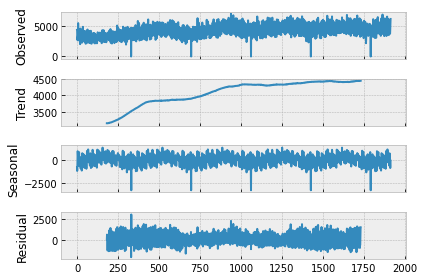

In [ ]:
#seasonal_decompose
weeks_per_year = 365

time_series = store_sum["CA_1"]
sj_sc = seasonal_decompose(time_series, freq= weeks_per_year)
sj_sc.plot()

plt.show()

In [ ]:
#Draw an image of the sales of one of the products in different regions
fig = make_subplots(3,1)

fig.add_trace(go.Scatter(x=np.arange(70),y=train_datasets.iloc[:,0],marker=dict(color='seagreen'),name='Train'),row=1,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=val_datasets.iloc[:,0],marker=dict(color='red'),name='Val'),row=1,col=1)

fig.add_trace(go.Scatter(x=np.arange(70),y=train_datasets.iloc[:,4],marker=dict(color='seagreen'), showlegend=False),row=2,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=val_datasets.iloc[:,4],marker=dict(color='red'), showlegend=False),row=2,col=1)

fig.add_trace(go.Scatter(x=np.arange(70),y=train_datasets.iloc[:,7],marker=dict(color='seagreen'), showlegend=False),row=3,col=1)
fig.add_trace(go.Scatter(x=np.arange(70,100),y=val_datasets.iloc[:,7],marker=dict(color='red'), showlegend=False),row=3,col=1)

fig.update_layout(title='Sales volume of a commodity')

In [ ]:
store_col = [0,4,7]

In [ ]:
def sarima_train_test(t_series, p = 2, d = 1, r = 2, NUM_TO_FORECAST = 56, do_plot_results = True):
    
    NUM_TO_FORECAST = NUM_TO_FORECAST  # Similar to train test splits.
    dates = np.arange(t_series.shape[0])
    
    model = SARIMAX(t_series, order = (p, d, r), trend = 'c')
    results = model.fit()
#     results.plot_diagnostics(figsize=(12, 8))
#     plt.show()

    forecast = results.get_prediction(start = - NUM_TO_FORECAST)
    mean_forecast = forecast.predicted_mean
    conf_int = forecast.conf_int()

    print(mean_forecast.shape)

    # Plot the forecast
#     plt.figure(figsize=(6,4))
#     plt.plot(dates[-NUM_TO_FORECAST:],
#             mean_forecast.values,
#             color = 'red',
#             label = 'forecast')


#     plt.plot(dates[-NUM_TO_FORECAST:],
#             t_series.iloc[-NUM_TO_FORECAST:],
#             color = 'blue',
#             label = 'actual')
#     plt.legend()
#     plt.title('Predicted vs. Actual Values')
#     plt.show()
    
    residuals = results.resid # Model residuals
    mae_sarima = np.mean(np.abs(residuals))
    print('Mean absolute error: ', mae_sarima)
    print(results.summary())
    return mean_forecast

In [ ]:
predictions = []

for col in store_col:
    predictions.append(sarima_train_test(train_datasets.iloc[:,col],NUM_TO_FORECAST=28))

predictions = np.array(predictions).reshape((-1, 28))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(28,)
Mean absolute error:  481.86153342339736
                           Statespace Model Results                           
Dep. Variable:                   CA_1   No. Observations:                   70
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -531.318
Date:                Sat, 19 Mar 2022   AIC                           1074.636
Time:                        05:51:34   BIC                           1088.041
Sample:                             0   HQIC                          1079.954
                                 - 70                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -34.7151     22.093     -1.571      0.116     -78.016       8.585
ar.L1          1.2396      0.025     49.122      0.000       1.190       1.289
ar.L2

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
predictions

array([[3521.31538338, 3813.92851939, 3358.03548754, 2340.70737537,
        2370.14732713, 2945.67333163, 3069.95296984, 3172.88539769,
        3782.34098292, 2990.17423226, 1903.10602384, 2240.70628181,
        2519.76848315, 3060.35278159, 3331.94912896, 3703.56335432,
        3087.47520834, 1885.77555906, 1814.99752304, 2519.15083772,
        3205.63628542, 3909.72232523, 4092.76912039, 3609.34207211,
        2849.94637333, 2535.41636252, 2995.52296634, 3672.46798554],
       [2106.57111641, 2389.47695414, 2300.74350805, 2264.02283839,
        2271.30671929, 2194.52373456, 2133.14251025, 2224.52535472,
        2211.51803914, 2373.50354039, 2129.2226026 , 2153.18840382,
        2041.07626797, 2140.00314389, 2084.64087886, 2273.49937876,
        2309.0843606 , 2126.4476686 , 2006.52650712, 2089.85204298,
        2014.90654963, 2340.46104847, 2287.3956534 , 2410.12566027,
        2095.52642436, 2194.69379389, 2084.42940211, 2191.29981353],
       [1854.31816354, 1825.36416774, 1296.366

In [ ]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_datasets.iloc[:,0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_datasets.iloc[:,0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_datasets.iloc[:,4].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_datasets.iloc[:,4].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_datasets.iloc[:,7].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_datasets.iloc[:,7].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="ARIMA")
fig.show()